In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
# torch
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torch.optim as optim
# model 
from utils.util_func import *
from utils.loss_functions import ChamferLossKL, calc_kl, calc_reconstruction_loss, VGGDistance
# datasets
from dataset.shapes_ds import generate_shape_dataset_torch

In [3]:
# training
# default hyper-parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

load_model = False


# ds specific hp
# ds = "shapes"
ds = "celeb"

run_prefix = ""
learn_order = False
use_logsoftmax = False
pad_mode = 'replicate'

use_tps = False
use_pairs = False


In [4]:
from dataset.celeba_dataset import CelebAPrunedAligned_MAFLVal, evaluate_lin_reg_on_mafl

# load data
image_size = 128
imwidth = 160
crop = 16
ch = 3
enc_channels = [32, 64, 128, 256]
prior_channels = (16, 32, 64)
root = '/home/kiki/dados_servidor/Servidor/Art/landmarks/celeba'
if use_tps:
    import utils.tps as tps
    if use_pairs:
        warper = tps.Warper(H=imwidth, W=imwidth, im1_multiplier=0.1, im1_multiplier_aff=0.1)
    else:
        warper = tps.WarperSingle(H=imwidth, W=imwidth, warpsd_all=0.001, warpsd_subset=0.01, transsd=0.1,
                                    scalesd=0.1, rotsd=5)
    print('using tps augmentation')
else:
    warper = None
dataset = CelebAPrunedAligned_MAFLVal(root=root, train=True, do_augmentations=False, imwidth=imwidth, crop=crop,
                                        pair_warper=warper)
milestones = (50, 100, 200)


In [5]:
# create dataloader
dataloader = DataLoader(dataset, shuffle=True, batch_size=64, num_workers=0, pin_memory=True,
                        drop_last=True)

In [6]:
imgs=next(iter(dataloader))
imgs['data'].shape

torch.Size([64, 3, 128, 128])

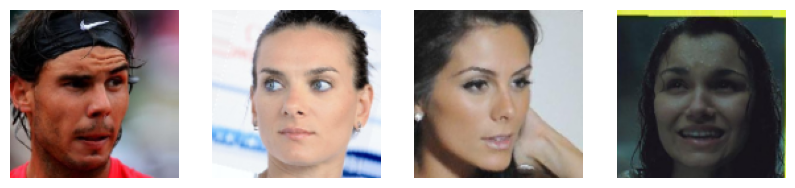

In [7]:
#get random indexes
idxs=np.random.randint(0,imgs['data'].shape[0],4)
sample_images=imgs['data'][idxs]
# plot
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    ax = fig.add_subplot(1, len(sample_images), i + 1)
    #change axis
    img=np.transpose(sample_images[i].numpy(), (1, 2, 0))
    ax.imshow(img)
    ax.set_axis_off()

## KeyPointVAE

The encoder is composed of two components:
1. **Position encoder**: outputs keypoints -- the spatial location $z_p = (x,y)$ of interesting areas, where $(x,y)$ are the coordinates of pixels.
2. **Appearance encoder**: extracts patches (or glimpses) of pre-determined size centered around $z_p$ and encodes them to latent variables $z_{\alpha}$.

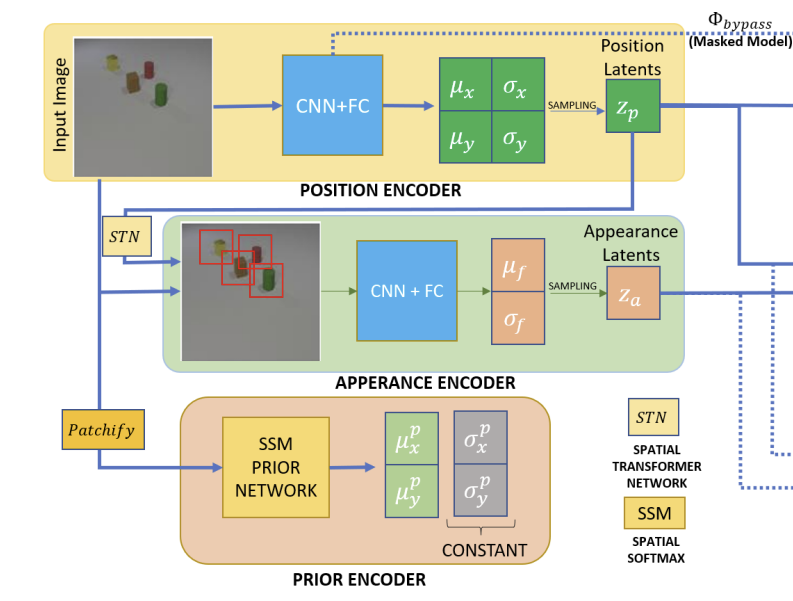

In [8]:
# modules
from modules.modules import KeyPointCNNOriginal, VariationalKeyPointPatchEncoder, SpatialSoftmaxKP, SpatialLogSoftmaxKP, \
    ToGaussianMapHW, CNNDecoder, ObjectEncoder, ObjectDecoderCNN, PointNetPPToCNN
# util functions
from utils.util_func import reparameterize, get_kp_mask_from_gmap, create_masks_fast


In [ ]:
#### CNN + FC ENCODER ####
from modules.modules import ConvBlock, ImagePatcher

class KeyPointCNNOriginal(nn.Module):
    """
    CNN to extract heatmaps, inspired by KeyNet (Jakab et.al)
    """

    def __init__(self, cdim=3, channels=(32, 64, 128, 256), image_size=64, n_kp=8, pad_mode='replicate',
                 use_resblock=False, first_conv_kernel_size=7):
        super(KeyPointCNNOriginal, self).__init__()
        self.cdim = cdim
        self.image_size = image_size
        self.n_kp = n_kp
        cc = channels[0]
        ch = cc
        first_conv_pad = first_conv_kernel_size // 2
        self.main = nn.Sequential()
        self.main.add_module(f'in_block_1',
                             ConvBlock(cdim, cc, kernel_size=first_conv_kernel_size, stride=1,
                                       pad=first_conv_pad, pool=False, pad_mode=pad_mode,
                                       use_resblock=use_resblock, relu_type='relu'))
        self.main.add_module(f'in_block_2',
                             ConvBlock(cc, cc, kernel_size=3, stride=1, pad=1, pool=False, pad_mode=pad_mode,
                                       use_resblock=use_resblock, relu_type='relu'))

        sz = image_size
        for ch in channels[1:]:
            self.main.add_module('conv_in_{}_0'.format(sz), ConvBlock(cc, ch, kernel_size=3, stride=2, pad=1,
                                                                      pool=False, pad_mode=pad_mode,
                                                                      use_resblock=use_resblock, relu_type='relu'))
            self.main.add_module('conv_in_{}_1'.format(ch), ConvBlock(ch, ch, kernel_size=3, stride=1, pad=1,
                                                                      pool=False, pad_mode=pad_mode,
                                                                      use_resblock=use_resblock, relu_type='relu'))
            cc, sz = ch, sz // 2

        self.keymap = nn.Conv2d(channels[-1], n_kp, kernel_size=1)
        self.conv_output_size = self.calc_conv_output_size()
        num_fc_features = torch.zeros(self.conv_output_size).view(-1).shape[0]
        print("conv shape: ", self.conv_output_size)
        # print("num fc features: ", num_fc_features)
        # self.fc = nn.Linear(num_fc_features, self.fc_output)

    def calc_conv_output_size(self):
        dummy_input = torch.zeros(1, self.cdim, self.image_size, self.image_size)
        dummy_input = self.main(dummy_input)
        return dummy_input[0].shape

    def forward(self, x):
        y = self.main(x)
        # heatmap
        hm = self.keymap(y)
        return y, hm


In [ ]:
#### FC+ CNN + DECODER ####

class CNNDecoder(nn.Module):
    """
    This module upsamples activation maps to to the original image size.
    """

    def __init__(self, cdim=3, channels=(64, 128, 256, 512, 512, 512), image_size=64, in_ch=16, n_kp=8,
                 pad_mode='zeros', use_resblock=False):
        super(CNNDecoder, self).__init__()
        self.cdim = cdim
        self.image_size = image_size
        cc = channels[-1]
        self.in_ch = in_ch
        self.n_kp = n_kp

        sz = 4

        self.main = nn.Sequential()
        self.main.add_module('depth_up',
                             ConvBlock(self.in_ch, cc, kernel_size=3, pad=1, upsample=True, pad_mode=pad_mode,
                                       use_resblock=use_resblock))
        for ch in reversed(channels[1:-1]):
            self.main.add_module('conv_to_{}'.format(sz * 2), ConvBlock(cc, ch, kernel_size=3, pad=1, upsample=True,
                                                                        pad_mode=pad_mode, use_resblock=use_resblock))
            cc, sz = ch, sz * 2

        self.main.add_module('conv_to_{}'.format(sz * 2),
                             ConvBlock(cc, self.n_kp * (channels[0] // self.n_kp + 1), kernel_size=3, pad=1,
                                       upsample=False,
                                       pad_mode=pad_mode, use_resblock=use_resblock))
        self.final_conv = ConvBlock(self.n_kp * (channels[0] // self.n_kp + 1), cdim, kernel_size=1, bias=True,
                                    activation=False, batchnorm=False)

    def forward(self, z, masks=None):
        y = self.main(z)
        if masks is not None:
            # this is not used in the paper
            # masks: [bs, n_kp, feat_dim, feat_dim]
            bs, n_kp, fs, _ = masks.shape
            # y: [bs, n_kp * ch[0], feat_dim, feat_dim]
            y = y.view(bs, n_kp, -1, fs, fs)
            y = masks.unsqueeze(2) * y
            y = y.view(bs, -1, fs, fs)
        y = self.final_conv(y)
        return y

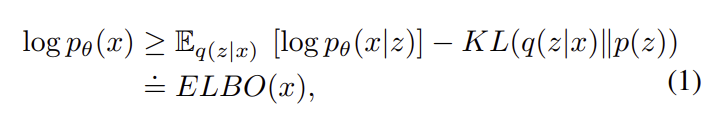

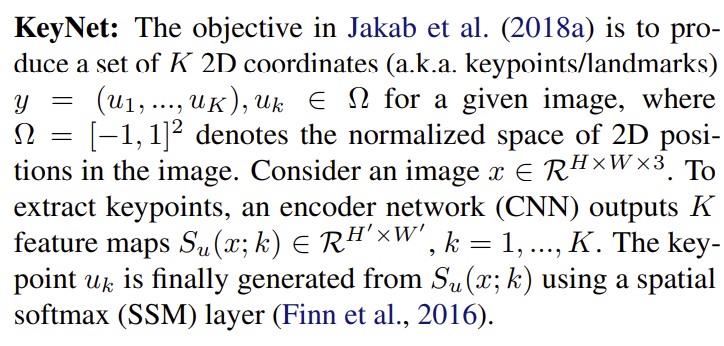

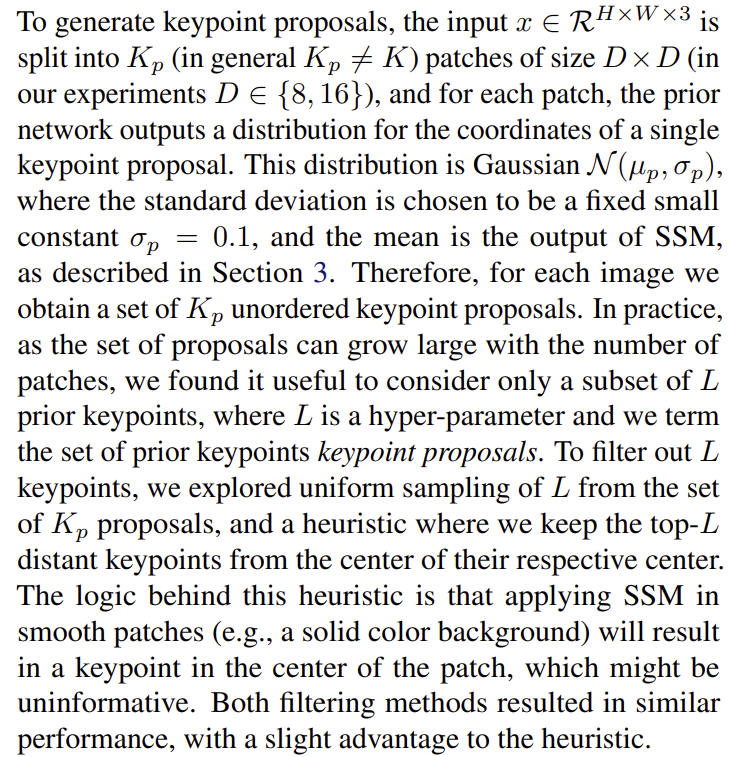

In [9]:
#### PRIOR NETWORK ####
class SpatialLogSoftmaxKP(torch.nn.Module):
    """
    This module performs spatial-softmax (ssm) by performing marginalization over heatmaps. Uses log-softmax
    for numerical stability. In practice, we do not use it, but feel free to explore it.
    """

    def __init__(self, kp_range=(0, 1)):
        super().__init__()
        self.kp_range = kp_range

    def forward(self, heatmap, probs=False):
        batch_size, n_kp, height, width = heatmap.shape
        # marginalize over height (y)
        s_h = torch.mean(heatmap, dim=3)  # [batch_size, n_kp, features_dim_height]
        sm_h = torch.log_softmax(s_h, dim=-1)  # [batch_size, n_kp, features_dim_height]
        # marginalize over width (x)
        s_w = torch.mean(heatmap, dim=2)  # [batch_size, n_kp, features_dim_width]
        sm_w = torch.log_softmax(s_w, dim=-1)  # [batch_size, n_kp, features_dim_width]
        # each coordinate [0, 1] is assigned a probability
        y_axis = torch.log(torch.linspace(self.kp_range[0], self.kp_range[1], height)).type_as(sm_h).expand(1, 1,
                                                                                                            -1).to(
            sm_h.device)
        # [1, 1, features_dim_height]
        # expected value: proability per coordinate * coordinate
        kp_h = torch.sum(torch.exp(sm_h + y_axis), dim=-1, keepdim=True)  # [batch_size, n_kp, 1]
        kp_h = kp_h.squeeze(-1)  # [batch_size, n_kp], y coordinate of each kp

        x_axis = torch.log(torch.linspace(self.kp_range[0], self.kp_range[1], width)).type_as(sm_w).expand(1, 1, -1).to(
            sm_w.device)
        # [1, 1, features_dim_width]
        kp_w = torch.sum(torch.exp(sm_w + x_axis), dim=-1, keepdim=True).squeeze(-1)
        # [batch_size, n_kp], x coordinate of each kp

        # stack keypoints
        kp = torch.stack([kp_h, kp_w], dim=-1)  # [batch_size, n_kp, 2], x, y coordinates of each kp

        if probs:
            return kp, sm_h, sm_w
        else:
            return kp



class VariationalKeyPointPatchEncoder(nn.Module):
    """
    This module encodes patches to KP via SSM. Additionally, we implement a variational version that encodes
    log-variance in addition to the mean, but we don't use it in practice, as constant prior std works better.
    We also experimented with extracting features directly from the patches for a prior for the visual features,
    but we didn't find it better than a constant prior (~N(0,1)). However, you can explore it by setting
    `learned_feature_dim`>0.
    """

    def __init__(self, cdim=3, channels=(16, 16, 32), image_size=64, n_kp=4, patch_size=16, kp_range=(0, 1),
                 use_logsoftmax=False, pad_mode='replicate', sigma=0.1, dropout=0.0, learnable_logvar=False,
                 learned_feature_dim=0):
        super(VariationalKeyPointPatchEncoder, self).__init__()
        self.use_logsoftmax = use_logsoftmax
        self.image_size = image_size
        self.dropout = dropout
        self.kp_range = kp_range
        self.n_kp = n_kp  # kp per patch
        self.patcher = ImagePatcher(cdim=cdim, image_size=image_size, patch_size=patch_size)
        self.features_dim = int(patch_size // (2 ** (len(channels) - 1)))
        self.enc = KeyPointCNNOriginal(cdim=cdim, channels=channels, image_size=patch_size, n_kp=n_kp,
                                       pad_mode=pad_mode, use_resblock=False, first_conv_kernel_size=3)
        self.ssm = SpatialLogSoftmaxKP(kp_range=kp_range) if use_logsoftmax else SpatialSoftmaxKP(kp_range=kp_range)
        self.sigma = sigma
        self.learnable_logvar = learnable_logvar
        self.learned_feature_dim = learned_feature_dim
        if self.learnable_logvar:
            self.to_logvar = nn.Sequential(nn.Linear(self.n_kp * (self.features_dim ** 2), 512),
                                           nn.ReLU(True),
                                           nn.Linear(512, 256),
                                           nn.ReLU(True),
                                           nn.Linear(256, self.n_kp * 2))  # logvar_x, logvar_y
        if self.learned_feature_dim > 0:
            self.to_features = nn.Sequential(nn.Linear(self.n_kp * (self.features_dim ** 2), 512),
                                             nn.ReLU(True),
                                             nn.Linear(512, 256),
                                             nn.ReLU(True),
                                             nn.Linear(256, self.n_kp * self.learned_feature_dim))  # logvar_x, logvar_y

    def img_to_patches(self, x):
        return self.patcher.img_to_patches(x)

    def patches_to_img(self, x):
        return self.patcher.patches_to_img(x)

    def get_global_kp(self, local_kp):
        # local_kp: [batch_size, num_patches, n_kp, 2]
        # returns the global coordinates of a KP within the original image.
        batch_size, num_patches, n_kp, _ = local_kp.shape
        global_coor = self.patcher.get_patch_location_idx().to(local_kp.device)  # [num_patches, 2]
        global_coor = global_coor[:, None, :].repeat(1, n_kp, 1)
        global_coor = (((local_kp - self.kp_range[0]) / (self.kp_range[1] - self.kp_range[0])) * (
                self.patcher.patch_size - 1) + global_coor) / (self.image_size - 1)
        global_coor = global_coor * (self.kp_range[1] - self.kp_range[0]) + self.kp_range[0]
        return global_coor

    def get_distance_from_patch_centers(self, kp, global_kp=False):
        # calculates the distance of a KP from the center of its parent patch. This is useful to understand (and filter)
        # if SSM detected something, otherwise, the KP will probably land in the center of the patch
        # (e.g., a solid-color patch will have the same activation in all pixels).
        if not global_kp:
            global_coor = self.get_global_kp(kp).view(kp.shape[0], -1, 2)
        else:
            global_coor = kp
        centers = 0.5 * (self.kp_range[1] + self.kp_range[0]) * torch.ones_like(kp).to(kp.device)
        global_centers = self.get_global_kp(centers.view(kp.shape[0], -1, self.n_kp, 2)).view(kp.shape[0], -1, 2)
        return ((global_coor - global_centers) ** 2).sum(-1)

    def encode(self, x, global_kp=False):
        # x: [batch_size, cdim, image_size, image_size]
        # global_kp: set True to get the global coordinates within the image (instead of local KP inside the patch)
        batch_size, cdim, image_size, image_size = x.shape
        x_patches = self.img_to_patches(x)  # [batch_size, cdim, num_patches, patch_size, patch_size]
        x_patches = x_patches.permute(0, 2, 1, 3, 4)  # [batch_size, num_patches, cdim, patch_size, patch_size]
        x_patches = x_patches.contiguous().view(-1, cdim, self.patcher.patch_size, self.patcher.patch_size)
        _, z = self.enc(x_patches)  # [batch_size*num_patches, n_kp, features_dim, features_dim]
        mu_kp = self.ssm(z, probs=False)  # [batch_size * num_patches, n_kp, 2]
        mu_kp = mu_kp.view(batch_size, -1, self.n_kp, 2)  # [batch_size, num_patches, n_kp, 2]
        if global_kp:
            mu_kp = self.get_global_kp(mu_kp)
        if self.learned_feature_dim > 0:
            mu_features = self.to_features(z.view(z.shape[0], -1))
            mu_features = mu_features.view(batch_size, -1, self.n_kp, self.learned_feature_dim)
            # [batch_size, num_patches, n_kp, learned_feature_dim]
        if self.learnable_logvar:
            logvar_kp = self.to_logvar(z.view(z.shape[0], -1))
            logvar_kp = logvar_kp.view(batch_size, -1, self.n_kp, 2)  # [batch_size, num_patches, n_kp, 2]
            if self.learned_feature_dim > 0:
                return mu_kp, logvar_kp, mu_features
            else:
                return mu_kp, logvar_kp
        elif self.learned_feature_dim > 0:
            return mu_kp, mu_features
        else:
            return mu_kp

    def forward(self, x, global_kp=False):
        return self.encode(x, global_kp)

In [9]:
def get_gaussian_map(self,z):
    gmap_1_fg = self.to_gauss_map(z[:, :-1], self.features_dim, self.features_dim)
    gmap_1_bg = 1 - gmap_1_fg.sum(1, keepdim=True).clamp(0, 1).detach()
    gmap_1 = torch.cat([gmap_1_fg, gmap_1_bg], dim=1)
    fg_masks_sep = get_kp_mask_from_gmap(gmap_1_fg, threshold=self.mask_threshold, binary=True,
                                            elementwise=True).detach()
    fg_masks = fg_masks_sep.sum(1, keepdim=True).clamp(0, 1)
    bg_masks = 1 - fg_masks
    masks = torch.cat([fg_masks.expand_as(gmap_1_fg), bg_masks], dim=1)
    masks_sep = torch.cat([fg_masks_sep, bg_masks], dim=1)
    return gmap_1, masks, masks_sep

def translate_patches(image_size, kp_batch, patches_batch, scale=None, translation=None):
        """
        translate patches to be centered around given keypoints
        kp_batch: [bs, n_kp, 2] in [-1, 1]
        patches: [bs, n_kp, ch_patches, patch_size, patch_size]
        scale: None or [bs, n_kp, 2] or [bs, n_kp, 1]
        translation: None or [bs, n_kp, 2] or [bs, n_kp, 1] (delta from kp)
        :return: translated_padded_pathces [bs, n_kp, ch, img_size, img_size]
        """
        batch_size, n_kp, ch_patch, patch_size, _ = patches_batch.shape
        img_size = image_size
        pad_size = (img_size - patch_size) // 2
        padded_patches_batch = F.pad(patches_batch, pad=[pad_size] * 4)
        delta_t_batch = 0.0 - kp_batch
        delta_t_batch = delta_t_batch.reshape(-1, delta_t_batch.shape[-1])  # [bs * n_kp, 2]
        padded_patches_batch = padded_patches_batch.reshape(-1, *padded_patches_batch.shape[2:])
        # [bs * n_kp, 3, patch_size, patch_size]
        zeros = torch.zeros([delta_t_batch.shape[0], 1], device=delta_t_batch.device).float()
        ones = torch.ones([delta_t_batch.shape[0], 1], device=delta_t_batch.device).float()

        if scale is None:
            scale_w = ones
            scale_h = ones
        elif scale.shape[-1] == 1:
            scale_w = scale[:, :-1].reshape(-1, scale.shape[-1])  # no need for bg kp
            scale_h = scale[:, :-1].reshape(-1, scale.shape[-1])  # no need for bg kp
        else:
            scale_h, scale_w = torch.split(scale[:, :-1], [1, 1], dim=-1)
            scale_w = scale_w.reshape(-1, scale_w.shape[-1])
            scale_h = scale_h.reshape(-1, scale_h.shape[-1])
        if translation is None:
            trans_w = zeros
            trans_h = zeros
        elif translation.shape[-1] == 1:
            trans_w = translation[:, :-1].reshape(-1, translation.shape[-1])  # no need for bg kp
            trans_h = translation[:, :-1].reshape(-1, translation.shape[-1])  # no need for bg kp
        else:
            trans_h, trans_w = torch.split(translation[:, :-1], [1, 1], dim=-1)
            trans_w = trans_w.reshape(-1, trans_w.shape[-1])
            trans_h = trans_h.reshape(-1, trans_h.shape[-1])

        theta = torch.cat([scale_h, zeros, delta_t_batch[:, 1].unsqueeze(-1) + trans_h,
                           zeros, scale_w, delta_t_batch[:, 0].unsqueeze(-1) + trans_w], dim=-1)

        theta = theta.view(-1, 2, 3)  # [batch_size * n_kp, 2, 3]
        align_corners = False
        padding_mode = 'zeros'
        # mode = "nearest"
        mode = 'bilinear'

        grid = F.affine_grid(theta, padded_patches_batch.size(), align_corners=align_corners)
        trans_padded_patches_batch = F.grid_sample(padded_patches_batch, grid, align_corners=align_corners,
                                                   mode=mode, padding_mode=padding_mode)

        trans_padded_patches_batch = trans_padded_patches_batch.view(batch_size, n_kp, *padded_patches_batch.shape[1:])
        # [bs, n_kp, ch, img_size, img_size]
        return trans_padded_patches_batch

In [12]:
class KeyPointVAE(nn.Module):
    def __init__(self, cdim=3, enc_channels=(16, 16, 32), prior_channels=(16, 16, 32), image_size=64, n_kp=1,
                 use_logsoftmax=False, pad_mode='replicate', sigma=0.1, dropout=0.0, dec_bone="gauss_pointnetpp",
                 patch_size=16, n_kp_enc=20, n_kp_prior=20, learned_feature_dim=16,
                 kp_range=(-1, 1), kp_activation="tanh", mask_threshold=0.2, anchor_s=0.25,
                 use_object_enc=False, use_object_dec=False, learn_order=False, exclusive_patches=False):
        super(KeyPointVAE, self).__init__()
        
        if dec_bone not in ["gauss_pointnetpp", "gauss_pointnetpp_feat"]:
            raise SystemError(f'unrecognized decoder backbone: {dec_bone}')
        print(f'decoder backbone: {dec_bone}')
        self.dec_bone = dec_bone
        self.image_size = image_size
        self.use_logsoftmax = use_logsoftmax
        self.sigma = sigma
        print(f'prior std: {self.sigma}')
        self.dropout = dropout
        self.kp_range = kp_range
        print(f'keypoints range: {self.kp_range}')
        self.num_patches = int((image_size // patch_size) ** 2)
        self.n_kp = n_kp
        self.n_kp_total = self.n_kp * self.num_patches
        self.n_kp_prior = min(self.n_kp_total, n_kp_prior)
        print(f'total number of kp: {self.n_kp_total} -> prior kp: {self.n_kp_prior}')
        self.n_kp_enc = n_kp_enc
        print(f'number of kp from encoder: {self.n_kp_enc}')
        self.kp_activation = kp_activation
        print(f'kp_activation: {self.kp_activation}')
        self.patch_size = patch_size
        self.features_dim = int(image_size // (2 ** (len(enc_channels) - 1)))
        self.learned_feature_dim = learned_feature_dim
        print(f'learnable feature dim: {learned_feature_dim}')
        self.mask_threshold = mask_threshold
        print(f'mask threshold: {self.mask_threshold}')
        self.anchor_s = anchor_s
        self.obj_patch_size = np.round(anchor_s * (image_size - 1)).astype(int)
        print(f'object patch size: {self.obj_patch_size}')
        self.use_object_enc = True if use_object_dec else use_object_enc
        self.use_object_dec = use_object_dec
        print(f'object encoder: {self.use_object_enc}, object decoder: {self.use_object_dec}')
        self.learn_order = learn_order
        print(f'learn particles order: {self.learn_order}')
        self.exclusive_patches = exclusive_patches

        # encoder
        self.enc = KeyPointCNNOriginal(cdim=cdim, channels=enc_channels, image_size=image_size, n_kp=self.n_kp_enc,
                                       pad_mode=pad_mode, use_resblock=False)
        enc_output_dim = 2 * 2
        # flatten feature maps and extract statistics
        self.to_normal_stats = nn.Sequential(nn.Linear(self.n_kp_enc * self.features_dim ** 2, 256),
                                             nn.ReLU(True),
                                             nn.Linear(256, 128),
                                             nn.ReLU(True),
                                             nn.Linear(128, self.n_kp_enc * enc_output_dim))
        self.aux_enc = None
        # object encoder
        object_enc_output_dim = self.learned_feature_dim * 2  # [mu_features, sigma_features]
        self.object_enc = nn.Sequential(nn.Linear(self.n_kp_enc * self.features_dim ** 2, 256),
                                        nn.ReLU(True),
                                        nn.Linear(256, 128),
                                        nn.ReLU(True),
                                        nn.Linear(128, object_enc_output_dim))
        self.object_enc_sep = ObjectEncoder(z_dim=learned_feature_dim, anchor_size=anchor_s,
                                                    image_size=self.features_dim, ch=self.n_kp_enc,
                                                    margin=0, cnn=False, encode_location=True)
        
        self.prior = VariationalKeyPointPatchEncoder(cdim=cdim, channels=prior_channels, image_size=image_size,
                                                     n_kp=n_kp, kp_range=self.kp_range,
                                                     patch_size=patch_size, use_logsoftmax=use_logsoftmax,
                                                     pad_mode=pad_mode, sigma=sigma, dropout=dropout,
                                                     learnable_logvar=False, learned_feature_dim=0)
        self.ssm = SpatialLogSoftmaxKP(kp_range=kp_range) if use_logsoftmax else SpatialSoftmaxKP(kp_range=kp_range)

        # decoder
        decoder_n_kp = 3 * self.n_kp_enc if self.dec_bone == "gauss_pointnetpp_feat" else 2 * self.n_kp_enc
        self.to_gauss_map = ToGaussianMapHW(sigma_w=sigma, sigma_h=sigma, kp_range=kp_range)
        self.pointnet = PointNetPPToCNN(axis_dim=2, target_hw=self.features_dim,
                                        n_kp=self.n_kp_enc, features_dim=self.learned_feature_dim,
                                        pad_mode=pad_mode,patch_size=patch_size)
        self.dec = CNNDecoder(cdim=cdim, channels=enc_channels, image_size=image_size, in_ch=decoder_n_kp,
                              n_kp=self.n_kp_enc + 1, pad_mode=pad_mode)
        self.object_dec = None
        self.init_weights()

    def get_parameters(self, prior=True, encoder=True, decoder=True):
        parameters = []
        if prior:
            parameters.extend(list(self.prior.parameters()))
        if encoder:
            parameters.extend(list(self.enc.parameters()))
            parameters.extend(list(self.to_normal_stats.parameters()))
            parameters.extend(list(self.object_enc.parameters()))
            if self.use_object_enc:
                parameters.extend(list(self.object_enc_sep.parameters()))
        if decoder:
            parameters.extend(list(self.dec.parameters()))
            parameters.extend(list(self.pointnet.parameters()))
        return parameters
    
    def set_require_grad(self, prior_value=True, enc_value=True, dec_value=True):
        for param in self.prior.parameters():
            param.requires_grad = prior_value
        for param in self.enc.parameters():
            param.requires_grad = enc_value
        for param in self.to_normal_stats.parameters():
            param.requires_grad = enc_value
        for param in self.object_enc.parameters():
            param.requires_grad = enc_value
        if self.use_object_enc:
            for param in self.object_enc_sep.parameters():
                param.requires_grad = enc_value
        for param in self.dec.parameters():
            param.requires_grad = dec_value
        for param in self.pointnet.parameters():
            param.requires_grad = dec_value

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # use pytorch's default
                pass

    def encode(self, x, return_heatmap=False, mask=None):
        _, z_kp = self.enc(x)  # [batch_size, n_kp, features_dim, features_dim]
        if mask is None:
            masked_hm = z_kp
        else:
            masked_hm = mask * z_kp
        z_kp_v = masked_hm.view(masked_hm.shape[0], -1)  # [batch_size, n_kp * features_dim * features_dim]
        stats = self.to_normal_stats(z_kp_v)  # [batch_size, n_kp * 4]
        stats = stats.view(stats.shape[0], self.n_kp_enc, 2 * 2)
        # [batch_size, n_kp, 4 + learned_feature_dim * 2]
        mu_enc, logvar_enc = torch.chunk(stats, chunks=2, dim=-1)  # [batch_size, n_kp, 2 + learned_feature_dim]
        mu, logvar = mu_enc[:, :, :2], logvar_enc[:, :, :2]  # [x, y]

        logvar_p = torch.log(torch.tensor(self.sigma ** 2, device=logvar.device))
        mu_obj_weight = None
        order_weights = None
        mu_features, logvar_features = None, None
        if self.kp_activation == "tanh":
            mu = torch.tanh(mu)
        elif self.kp_activation == "sigmoid":
            mu = torch.sigmoid(mu)

        mu = torch.cat([mu, torch.zeros_like(mu[:, 0]).unsqueeze(1)], dim=1)
        logvar = torch.cat([logvar, logvar_p * torch.ones_like(logvar[:, 0]).unsqueeze(1)], dim=1)

        if return_heatmap:
            return mu, logvar, z_kp, mu_features, logvar_features, mu_obj_weight, order_weights
        else:
            return mu, logvar, mu_features, logvar_features, mu_obj_weight, order_weights

    def encode_prior(self, x):
        return self.prior(x)

    def decode(self, z):
        return self.dec(z)

    def get_prior_kp(self, x, probs=False):
        _, z = self.encode_prior(x)
        return self.ssm(z, probs)
    

    def decode_all(self, z, z_features, kp_heatmap, obj_on, deterministic=False, order_weights=None):
        gmap_1_fg = self.to_gauss_map(z[:, :-1], self.features_dim, self.features_dim)
        gmap_1_bg = 1 - gmap_1_fg.sum(1, keepdim=True).clamp(0, 1).detach()
        gmap_1 = torch.cat([gmap_1_fg, gmap_1_bg], dim=1)
        fg_masks_sep = get_kp_mask_from_gmap(gmap_1_fg, threshold=self.mask_threshold, binary=True,
                                             elementwise=True).detach()
        fg_masks = fg_masks_sep.sum(1, keepdim=True).clamp(0, 1)
        bg_masks = 1 - fg_masks
        masks = torch.cat([fg_masks.expand_as(gmap_1_fg), bg_masks], dim=1)
        # decode object and translate them to the positions of the keypoints
        # decode
        z_features_in = z_features
        if self.dec_bone == "gauss_pointnetpp":
            if self.learned_feature_dim > 0:
                gmap_2 = self.pointnet(position=z.detach(),
                                       features=torch.cat([z.detach(), z_features_in], dim=-1))
            else:
                gmap_2 = self.pointnet(position=z.detach(), features=z.detach())
            gmap = torch.cat([gmap_1[:, :-1], gmap_2], dim=1)
        elif self.dec_bone == "gauss_pointnetpp_feat":
            if self.learned_feature_dim > 0:
                gmap_2 = self.pointnet(position=z.detach(),
                                       features=torch.cat([z.detach(), z_features_in], dim=-1))
            else:
                gmap_2 = self.pointnet(position=z.detach(), features=z.detach())

            fg_masks = masks[:, :-1]
            bg_masks = masks[:, -1].unsqueeze(1)
            gmap_2 = fg_masks * gmap_2
            gmap_3 = bg_masks * kp_heatmap.detach()
            gmap = torch.cat([gmap_1[:, :-1], gmap_2, gmap_3], dim=1)
        else:
            raise NotImplementedError('grow a dec bone')
        rec = self.dec(gmap)

        if z_features is not None and self.use_object_dec:
            object_dec_out = self.decode_objects(z, z_features, obj_on, deterministic=deterministic,
                                                 order_weights=order_weights, bg=rec)
            dec_objects, dec_objects_trans, rec = object_dec_out
        else:
            dec_objects_trans = None
            dec_objects = None
        return rec, dec_objects, dec_objects_trans

    def encode_object_features_sep(self, x, kp, features_map, masks, exclusive_patches=False, obj_on=None):
        # x: [bs, ch, image_size, image_size]
        # kp :[bs, n_kp, 2]
        # features_map: [bs, n_kp, features_dim, features_dim]
        # masks: [bs, n_kp, features_dim, features_dim]

        batch_size, n_kp, features_dim, _ = masks.shape

        # object features
        obj_enc_out = self.object_enc_sep(x, kp.detach(), exclusive_patches=exclusive_patches, obj_on=obj_on)
        mu_obj, logvar_obj, cropped_objects = obj_enc_out[0], obj_enc_out[1], obj_enc_out[2]
        if len(obj_enc_out) > 3:
            cropped_objects_masks = obj_enc_out[3]
        else:
            cropped_objects_masks = None

        # bg beatures
        bg_mask = masks[:, -1].unsqueeze(1)  # [bs, 1, features_dim, features_dim]
        
        masked_features = bg_mask.unsqueeze(2) * features_map.unsqueeze(1)  # [bs, 1, n_kp, f_dim, f_dim]
        masked_features = masked_features.view(batch_size, masked_features.shape[1], -1)  # flatten
        object_enc_out = self.object_enc(masked_features)  # [bs, 1, 2 * learned_features_dim]
        mu_bg, logvar_bg = object_enc_out.chunk(2, dim=-1)

        mu_features = torch.cat([mu_obj, mu_bg], dim=1)
        logvar_features = torch.cat([logvar_obj, logvar_bg], dim=1)

        return mu_features, logvar_features, cropped_objects, cropped_objects_masks

    def forward(self, x, deterministic=False, detach_decoder=False, x_prior=None, warmup=False, stg=False,
                noisy_masks=False):
        # stg: straight-through-gradients. not used.
        
        ####### Prior Encoder ########
        # first, extract prior KP proposals
        # prior
        if x_prior is None:
            x_prior = x
        kp_p = self.prior(x_prior, global_kp=True)
        kp_p = kp_p.view(x_prior.shape[0], -1, 2)  # [batch_size, n_kp_total, 2]
        # filter proposals by distance to the patches' center
        dist_from_center = self.prior.get_distance_from_patch_centers(kp_p, global_kp=True)
        _, indices = torch.topk(dist_from_center, k=self.n_kp_prior, dim=-1, largest=True)
        batch_indices = torch.arange(kp_p.shape[0]).view(-1, 1).to(kp_p.device)
        kp_p = kp_p[batch_indices, indices]
        # alternatively, just sample random kp
        # kp_p = kp_p[:, torch.randperm(kp_p.shape[1])[:self.n_kp_prior]]

        ####### Position Encoder ########
        # encode posterior KP
        mu, logvar, kp_heatmap, mu_features, logvar_features, obj_on, order_weights = self.encode(x,
                                                                                                  return_heatmap=True)
        if deterministic:
            z = mu
        else:
            z = reparameterize(mu, logvar)

        # create gaussian maps (and masks) from the posterior keypoints
        gmap_1, masks, masks_sep=get_gaussian_map(self,z)
        print('gaussian map', gmap_1.shape)
        print('masks', masks.shape)
        print('masks_sep', masks_sep.shape)

        ####### Apperance Encoder ########
        # encode visual features
        feat_source = x if self.use_object_dec else kp_heatmap.detach()
        obj_on_in = obj_on if not noisy_masks else 0.0 * obj_on + torch.rand_like(obj_on)
        obj_enc_out = self.encode_object_features_sep(feat_source, mu[:, :-1], kp_heatmap.detach(),
                                                        masks_sep.detach(),
                                                        exclusive_patches=self.exclusive_patches,
                                                        obj_on=obj_on_in)
        mu_features, logvar_features, cropped_objects = obj_enc_out[0], obj_enc_out[1], obj_enc_out[2]
        print('mu_features', mu_features.shape)
        print('logvar_features', logvar_features.shape)
        print('cropped_objects', cropped_objects.shape)
        a=2/0
        if len(obj_enc_out) > 3:
            cropped_objects_masks = obj_enc_out[3]
        else:
            cropped_objects_masks = None
        # mu_features, logvar_features = self.encode_object_features(kp_heatmap.detach(), masks_sep)
        # cropped_objects = None
        # cropped_objects_masks = None

        if deterministic:
            z_features = mu_features
        else:
            z_features = reparameterize(mu_features, logvar_features)

        # decode
        if not warmup or not self.use_object_dec:
            z_features_fg, z_features_bg = torch.split(z_features, [self.n_kp_enc, 1], dim=1)
            z_features_in = torch.cat([z_features_fg.detach(), z_features_bg],
                                      dim=1) if self.use_object_dec else z_features
            if self.dec_bone == "gauss_pointnetpp":
                if self.learned_feature_dim > 0:
                    gmap_2 = self.pointnet(position=z.detach(),
                                           features=torch.cat([z.detach(), z_features_in], dim=-1))
                else:
                    gmap_2 = self.pointnet(position=z.detach(), features=z.detach())
                # print('x', x.shape)
                # print('gmap_2', gmap_2.shape)
                # print('gmap_1', gmap_1.shape)
                gmap = torch.cat([gmap_1[:, :-1], gmap_2], dim=1)
                # gmap = torch.cat([gmap_2.detach(), gmap_2], dim=1)
            elif self.dec_bone == "gauss_pointnetpp_feat":
                if self.learned_feature_dim > 0:
                    gmap_2 = self.pointnet(position=z.detach(),
                                           features=torch.cat([z.detach(), z_features_in], dim=-1))
                else:
                    gmap_2 = self.pointnet(position=z.detach(), features=z.detach())

                fg_masks = masks[:, :-1]
                bg_masks = masks[:, -1].unsqueeze(1)
                gmap_2 = fg_masks * gmap_2
                gmap_3 = bg_masks * kp_heatmap.detach()
                gmap = torch.cat([gmap_1[:, :-1], gmap_2, gmap_3], dim=1)
            else:
                raise NotImplementedError('grow a dec bone')
            if detach_decoder:
                rec = self.dec(gmap.detach())
            else:
                rec = self.dec(gmap)
        else:
            rec = torch.zeros_like(x)
            gmap = None

        
        dec_objects_trans = None
        dec_objects = None
        gmap = None

        output_dict = {}
        output_dict['kp_p'] = kp_p
        output_dict['gmap'] = gmap
        output_dict['rec'] = rec
        output_dict['mu'] = mu
        output_dict['logvar'] = logvar
        output_dict['mu_features'] = mu_features
        output_dict['logvar_features'] = logvar_features
        # object stuff
        output_dict['cropped_objects_original'] = cropped_objects
        output_dict['cropped_objects_masks'] = cropped_objects_masks
        output_dict['obj_on'] = obj_on
        output_dict['dec_objects_original'] = dec_objects
        output_dict['dec_objects'] = dec_objects_trans
        output_dict['order_weights'] = order_weights

        return output_dict


## Train

In [13]:
lr = 1e-3
batch_size = 64
num_epochs = 100
eval_epoch_freq = 2
warmup_epoch = 1

n_kp = 1  # num kp per patch
mask_threshold = 0.2  # mask threshold for the features from the encoder
kp_range = (-1, 1)
weight_decay = 0.0
sigma = 0.1  # default sigma for the gaussian maps
dropout = 0.0
kp_activation = "tanh"
iou_thresh = 0.2

beta_kl = 0.05
beta_rec = 1.0
n_kp_enc = 10  # total kp to output from the encoder / filter from prior
n_kp_prior = 15
patch_size = 16
learned_feature_dim = 6  # additional features than x,y for each kp
# dec_bone = "gauss_pointnetpp"  # object model
dec_bone = "gauss_pointnetpp_feat"  # object model
topk = min(10, n_kp_enc)  # display top-10 kp with smallest variance
recon_loss_type = "mse"

anchor_s = 0.25
kl_balance = 0.001
exclusive_patches = False

use_object_enc = True  # separate object encoder
use_object_dec = False  # separate object decoder

# save hyper-parameters
hparams = {'ds': ds, 'batch_size': batch_size, 'lr': lr, 'kp_activation': kp_activation, 'pad_mode': pad_mode,
           'num_epochs': num_epochs, 'n_kp': n_kp, 'recon_loss_type': recon_loss_type,
           'use_logsoftmax': use_logsoftmax, 'sigma': sigma, 'beta_kl': beta_kl, 'beta_rec': beta_rec,
           'dec_bone': dec_bone, 'patch_size': patch_size, 'topk': topk, 'n_kp_enc': n_kp_enc,
           'eval_epoch_freq': eval_epoch_freq, 'learned_feature_dim': learned_feature_dim,
           'n_kp_prior': n_kp_prior, 'weight_decay': weight_decay, 'kp_range': kp_range,
           'run_prefix': run_prefix, 'mask_threshold': mask_threshold, 'use_tps': use_tps, 'use_pairs': use_pairs,
           'use_object_enc': use_object_enc, 'use_object_dec': use_object_dec, 'warmup_epoch': warmup_epoch,
           'iou_thresh': iou_thresh, 'anchor_s': anchor_s, 'learn_order': learn_order, 'kl_balance': kl_balance,
           'milestones': milestones, 'image_size': image_size, 'enc_channels': enc_channels,
           'prior_channels': prior_channels, 'exclusive_patches': exclusive_patches}

# model
model = KeyPointVAE(cdim=ch, enc_channels=enc_channels, prior_channels=prior_channels,
                    image_size=image_size, n_kp=n_kp, learned_feature_dim=learned_feature_dim,
                    use_logsoftmax=use_logsoftmax, pad_mode=pad_mode, sigma=sigma,
                    dropout=dropout, dec_bone=dec_bone, patch_size=patch_size, n_kp_enc=n_kp_enc,
                    n_kp_prior=n_kp_prior, kp_range=kp_range, kp_activation=kp_activation,
                    mask_threshold=mask_threshold, use_object_enc=use_object_enc,
                    exclusive_patches=exclusive_patches, use_object_dec=use_object_dec, anchor_s=anchor_s,
                    learn_order=learn_order).to(device)

decoder backbone: gauss_pointnetpp_feat
prior std: 0.1
keypoints range: (-1, 1)
total number of kp: 64 -> prior kp: 15
number of kp from encoder: 10
kp_activation: tanh
learnable feature dim: 6
mask threshold: 0.2
object patch size: 32
object encoder: True, object decoder: False
learn particles order: False
conv shape:  torch.Size([256, 16, 16])
conv shape:  torch.Size([64, 4, 4])


In [14]:
logvar_p = torch.log(torch.tensor(sigma ** 2)).to(device)  # logvar of the constant std -> for the kl
# prepare saving location
run_name = f'{ds}_dlp_{dec_bone}' + run_prefix
log_dir = prepare_logdir(runname=run_name, src_dir='./')
fig_dir = os.path.join(log_dir, 'figures')
save_dir = os.path.join(log_dir, 'saves')
save_config(log_dir, hparams)

kl_loss_func = ChamferLossKL(use_reverse_kl=False)
if recon_loss_type == "vgg":
    recon_loss_func = VGGDistance(device=device)
else:
    recon_loss_func = calc_reconstruction_loss
betas = (0.9, 0.999)
eps = 1e-4
# we use separate optimizers for the encoder and decoder, but it is not really necessary...
optimizer_e = optim.Adam(model.get_parameters(encoder=True, prior=True, decoder=False), lr=lr, betas=betas, eps=eps,
                            weight_decay=weight_decay)
optimizer_d = optim.Adam(model.get_parameters(encoder=False, prior=False, decoder=True), lr=lr, betas=betas,
                            eps=eps, weight_decay=weight_decay)

scheduler_e = optim.lr_scheduler.MultiStepLR(optimizer_e, milestones=milestones, gamma=0.5)
scheduler_d = optim.lr_scheduler.MultiStepLR(optimizer_d, milestones=milestones, gamma=0.5)

if load_model:
    try:
        model.load_state_dict(
            torch.load(os.path.join(save_dir, f'{ds}_dlp_{dec_bone}.pth'), map_location=device))
        print("loaded model from checkpoint")
    except:
        print("model checkpoint not found")

In [15]:
def plot(losses,losses_kl,losses_kl_kp,losses_kl_feat,linreg_errors,linreg_logvar_errors,linreg_features_errors,valid_losses):
    # plot graphs
    num_plots = 3
    fig = plt.figure()
    ax = fig.add_subplot(num_plots, 1, 1)
    ax.plot(np.arange(len(losses[1:])), losses[1:], label="loss")
    ax.set_title(run_name)
    ax.legend()

    ax = fig.add_subplot(num_plots, 1, 2)
    ax.plot(np.arange(len(losses_kl[1:])), losses_kl[1:], label="kl", color='red')
    if learned_feature_dim > 0:
        ax.plot(np.arange(len(losses_kl_kp[1:])), losses_kl_kp[1:], label="kl_kp", color='cyan')
        ax.plot(np.arange(len(losses_kl_feat[1:])), losses_kl_feat[1:], label="kl_feat", color='green')
    ax.legend()

    if ds == 'celeb':
        ax = fig.add_subplot(num_plots, 1, 4)
        ax.plot(np.arange(len(linreg_errors[1:])), linreg_errors[1:], label="linreg_err %")
        ax.plot(np.arange(len(linreg_logvar_errors[1:])), linreg_logvar_errors[1:], label="linreg_v_err %")
        if learned_feature_dim > 0:
            ax.plot(np.arange(len(linreg_features_errors[1:])), linreg_features_errors[1:],
                    label="linreg_f_err %")
        ax.legend()
    else:
        ax = fig.add_subplot(num_plots, 1, 4)
        ax.plot(np.arange(len(valid_losses[1:])), valid_losses[1:], label="valid_loss", color='magenta')
        ax.legend()
    plt.tight_layout()
    plt.savefig(f'{fig_dir}/{run_name}_graph.jpg')
    plt.close('all')

In [16]:
def calculate_reconstruction_loss(epoch,x, rec_x,batch_psnrs,psnr, use_object_dec, dec_objects_original, cropped_objects_original):
    # reconstruction error
    if use_object_dec and dec_objects_original is not None and epoch < warmup_epoch:
        # reconstruct patches in the warmup stage
        if recon_loss_type == "vgg":
            _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
            dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
            cropped_objects_original = cropped_objects_original.reshape(-1,
                                                                        *cropped_objects_original.shape[2:])
            # vgg has a minimal input size, so we interpolate if the patch is too small
            if cropped_objects_original.shape[-1] < 32:
                cropped_objects_original = F.interpolate(cropped_objects_original, size=32, mode='bilinear',
                                                         align_corners=False)
                dec_objects_rgb = F.interpolate(dec_objects_rgb, size=32, mode='bilinear',
                                                align_corners=False)
            loss_rec_obj = recon_loss_func(cropped_objects_original, dec_objects_rgb, reduction="mean")

        else:
            _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
            dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
            cropped_objects_original = cropped_objects_original.clone().reshape(-1,
                                                                                *cropped_objects_original.shape[
                                                                                 2:])
            loss_rec_obj = calc_reconstruction_loss(cropped_objects_original, dec_objects_rgb,
                                                    loss_type='mse', reduction='mean')

        loss_rec = loss_rec_obj
    else:
        # reconstruct full image
        if recon_loss_type == "vgg":
            loss_rec = recon_loss_func(x, rec_x, reduction="mean")
        else:
            loss_rec = calc_reconstruction_loss(x, rec_x, loss_type='mse', reduction='mean')

        with torch.no_grad():
            psnr = -10 * torch.log10(F.mse_loss(rec_x, x))
            batch_psnrs.append(psnr.data.cpu().item())

    return loss_rec,batch_psnrs,psnr

In [17]:
def evaluate(x,x_prior,model_output,mu,mu_p,logvar,rec_x,dec_objects_original,cropped_objects_original,use_object_dec,epoch):
    max_imgs = 8
    img_with_kp = plot_keypoints_on_image_batch(mu[:, :-1].clamp(min=kp_range[0], max=kp_range[1]),
                                                x, radius=3, thickness=1, max_imgs=max_imgs, kp_range=kp_range)
    img_with_kp_p = plot_keypoints_on_image_batch(mu_p, x_prior, radius=3, thickness=1, max_imgs=max_imgs,
                                                    kp_range=kp_range)
    # top-k
    with torch.no_grad():
        logvar_sum = logvar[:, :-1].sum(-1)
        logvar_topk = torch.topk(logvar_sum, k=topk, dim=-1, largest=False)
        indices = logvar_topk[1]  # [batch_size, topk]
        batch_indices = torch.arange(mu.shape[0]).view(-1, 1).to(mu.device)
        topk_kp = mu[batch_indices, indices]
        # bounding boxes
        masks = create_masks_fast(mu[:, :-1].detach(), anchor_s=model.anchor_s, feature_dim=x.shape[-1])
        masks = torch.where(masks < mask_threshold, 0.0, 1.0)
        bb_scores = -1 * logvar_sum
        hard_threshold = bb_scores.mean()
    if use_object_dec:
        img_with_masks_nms, nms_ind = plot_bb_on_image_batch_from_masks_nms(masks, x, scores=bb_scores,
                                                                            iou_thresh=iou_thresh,
                                                                            thickness=1, max_imgs=max_imgs,
                                                                            hard_thresh=hard_threshold)
        # hard_thresh: a general threshold for bb scores (set None to not use it)
        bb_str = f'bb scores: max: {bb_scores.max():.2f}, min: {bb_scores.min():.2f},' \
                    f' mean: {bb_scores.mean():.2f}\n'
        print(bb_str)
    log_line(log_dir, bb_str)
    img_with_kp_topk = plot_keypoints_on_image_batch(topk_kp.clamp(min=kp_range[0], max=kp_range[1]), x,
                                                        radius=3, thickness=1, max_imgs=max_imgs,
                                                        kp_range=kp_range)
    if use_object_dec and dec_objects_original is not None:
        dec_objects = model_output['dec_objects']
        vutils.save_image(torch.cat([x[:max_imgs, -3:], img_with_kp[:max_imgs, -3:].to(device),
                                        rec_x[:max_imgs, -3:], img_with_kp_p[:max_imgs, -3:].to(device),
                                        img_with_kp_topk[:max_imgs, -3:].to(device),
                                        dec_objects[:max_imgs, -3:],
                                        img_with_masks_nms[:max_imgs, -3:].to(device)],
                                    dim=0).data.cpu(), '{}/image_{}.jpg'.format(fig_dir, epoch),
                            nrow=8, pad_value=1)
        with torch.no_grad():
            _, dec_objects_rgb = torch.split(dec_objects_original, [1, 3], dim=2)
            dec_objects_rgb = dec_objects_rgb.reshape(-1, *dec_objects_rgb.shape[2:])
            cropped_objects_original = cropped_objects_original.clone().reshape(-1, 3,
                                                                                cropped_objects_original.shape[
                                                                                    -1],
                                                                                cropped_objects_original.shape[
                                                                                    -1])
            if cropped_objects_original.shape[-1] != dec_objects_rgb.shape[-1]:
                cropped_objects_original = F.interpolate(cropped_objects_original,
                                                            size=dec_objects_rgb.shape[-1],
                                                            align_corners=False, mode='bilinear')
        vutils.save_image(
            torch.cat([cropped_objects_original[:max_imgs * 2, -3:], dec_objects_rgb[:max_imgs * 2, -3:]],
                        dim=0).data.cpu(), '{}/image_obj_{}.jpg'.format(fig_dir, epoch),
            nrow=8, pad_value=1)
    else:
        vutils.save_image(torch.cat([x[:max_imgs, -3:], img_with_kp[:max_imgs, -3:].to(device),
                                        rec_x[:max_imgs, -3:], img_with_kp_p[:max_imgs, -3:].to(device),
                                        img_with_kp_topk[:max_imgs, -3:].to(device)],
                                    dim=0).data.cpu(), '{}/image_{}.jpg'.format(fig_dir, epoch),
                            nrow=8, pad_value=1)
    torch.save(model.state_dict(),
                os.path.join(save_dir, f'{ds}_dlp_{dec_bone}{run_prefix}.pth'))


In [18]:
dec_bone='gauss_pointnetpp_feat'

In [19]:
from utils_loss import calculate_reconstruction_loss,evaluate,evaluate_sup_linear_reg,plot

# statistics
losses = []
losses_rec = []
losses_kl = []
losses_kl_kp = []
losses_kl_feat = []

# initialize linear regression statistics (celeba)
linreg_error = best_linreg_error = 1.0
best_linreg_epoch = 0
linreg_logvar_error = best_linreg_logvar_error = 1.0
best_linreg_logvar_epoch = 0
linreg_features_error = best_linreg_features_error = 1.0
best_linreg_features_epoch = 0

linreg_errors = []
linreg_logvar_errors = []
linreg_features_errors = []

# initialize validation statistics
valid_loss = best_valid_loss = 1e8
valid_losses = []
best_valid_epoch = 0

# save PSNR values of the reconstruction
psnrs = []

for epoch in range(num_epochs):
    model.train()
    batch_losses = []
    batch_losses_rec = []
    batch_losses_kl = []
    batch_losses_kl_kp = []
    batch_losses_kl_feat = []
    batch_psnrs = []
    psnr=0
    pbar = tqdm(iterable=dataloader)
    for batch in pbar:
        if len(batch['data'].shape) == 5:
            x_prior = batch['data'][:, 0].to(device)
            x = batch['data'][:, 1].to(device)
        else:
            x = batch['data'].to(device)
            x_prior = x
    
        batch_size = x.shape[0]
        # forward pass
        # noisy_masks = (epoch < 5 * warmup_epoch)  # add small noise to the alpha masks
        noisy_masks=False
        # model_output = model(x, x_prior=x_prior, warmup=(epoch < warmup_epoch), noisy_masks=noisy_masks)
        model_output = model(x, x_prior=x_prior, warmup=False, noisy_masks=noisy_masks)
        mu_p = model_output['kp_p']
        gmap = model_output['gmap']
        mu = model_output['mu']
        logvar = model_output['logvar']
        rec_x = model_output['rec']
        mu_features = model_output['mu_features']
        logvar_features = model_output['logvar_features']
        # object stuff
        dec_objects_original = model_output['dec_objects_original']
        cropped_objects_original = model_output['cropped_objects_original']
        obj_on = model_output['obj_on']  # [batch_size, n_kp]

        loss_rec,batch_psnrs,psnr= calculate_reconstruction_loss(epoch,warmup_epoch,
                                        x, rec_x,recon_loss_func,recon_loss_type,batch_psnrs,
                                        psnr, use_object_dec, dec_objects_original, 
                                        cropped_objects_original)


        # kl-divergence
        logvar_kp = logvar_p.expand_as(mu_p)

        # the final kp is the bg kp which is located in the center (so no need for it)
        # to reproduce the results on celeba, use `mu_post = mu`, `logvar_post = logvar`
        mu_post = mu[:, :-1]
        logvar_post = logvar[:, :-1]
        # mu_post = mu
        # logvar_post = logvar
        mu_prior = mu_p
        logvar_prior = logvar_kp

        loss_kl_kp = kl_loss_func(mu_preds=mu_post, logvar_preds=logvar_post, mu_gts=mu_prior,
                                    logvar_gts=logvar_prior).mean()

        if learned_feature_dim > 0:
            loss_kl_feat = calc_kl(logvar_features.view(-1, logvar_features.shape[-1]),
                                    mu_features.view(-1, mu_features.shape[-1]), reduce='none')
            loss_kl_feat = loss_kl_feat.view(batch_size, n_kp_enc + 1).sum(1).mean()
        else:
            loss_kl_feat = torch.tensor(0.0, device=device)
        loss_kl = loss_kl_kp + kl_balance * loss_kl_feat

        loss = beta_rec * loss_rec + beta_kl * loss_kl
        # backprop
        optimizer_e.zero_grad()
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_e.step()
        optimizer_d.step()
        # log
        batch_losses.append(loss.data.cpu().item())
        batch_losses_rec.append(loss_rec.data.cpu().item())
        batch_losses_kl.append(loss_kl.data.cpu().item())
        batch_losses_kl_kp.append(loss_kl_kp.data.cpu().item())
        batch_losses_kl_feat.append(loss_kl_feat.data.cpu().item())
        # progress bar
        if use_object_dec and epoch < warmup_epoch:
            pbar.set_description_str(f'epoch #{epoch} (warmup)')
        elif use_object_dec and noisy_masks:
            pbar.set_description_str(f'epoch #{epoch} (noisy masks)')
        else:
            pbar.set_description_str(f'epoch #{epoch}')
        pbar.set_postfix(loss=loss.data.cpu().item(), rec=loss_rec.data.cpu().item(),
                            kl=loss_kl.data.cpu().item())
    pbar.close()
    losses.append(np.mean(batch_losses))
    losses_rec.append(np.mean(batch_losses_rec))
    losses_kl.append(np.mean(batch_losses_kl))
    losses_kl_kp.append(np.mean(batch_losses_kl_kp))
    losses_kl_feat.append(np.mean(batch_losses_kl_feat))
    if len(batch_psnrs) > 0:
        psnrs.append(np.mean(batch_psnrs))
    # keep track of bounding box scores to set a hard threshold (as bb scores are not normalized)
    # epoch_bb_scores = torch.cat(batch_bb_scores, dim=0)
    # bb_mean_score = epoch_bb_scores.mean().data.cpu().item()
    # bb_mean_scores.append(bb_mean_score)
    # schedulers
    scheduler_e.step()
    scheduler_d.step()
    # epoch summary
    log_str = f'epoch {epoch} summary for dec backbone: {dec_bone}\n'
    log_str += f'loss: {losses[-1]:.3f}, rec: {losses_rec[-1]:.3f}, kl: {losses_kl[-1]:.3f}\n'
    log_str += f'kl_balance: {kl_balance:.4f}, kl_kp: {losses_kl_kp[-1]:.3f}, kl_feat: {losses_kl_feat[-1]:.3f}\n'
    log_str += f'mu max: {mu.max()}, mu min: {mu.min()}\n'
    if ds != 'celeb':
        log_str += f'val loss (freq: {eval_epoch_freq}): {valid_loss:.3f},' \
                    f' best: {best_valid_loss:.3f} @ epoch: {best_valid_epoch}\n'
    if obj_on is not None:
        log_str += f'obj_on max: {obj_on.max()}, obj_on min: {obj_on.min()}\n'
    if len(psnrs) > 0:
        log_str += f'mean psnr: {psnrs[-1]:.3f}\n'
    print(log_str)
    log_line(log_dir, log_str)

    if epoch % eval_epoch_freq == 0 or epoch == num_epochs - 1:
        evaluate(x,x_prior,model,model_output,mu,mu_p,topk,mask_threshold,iou_thresh,
                    logvar,rec_x,dec_objects_original,cropped_objects_original,use_object_dec,
                    kp_range,epoch,fig_dir,log_dir,save_dir,ds,dec_bone,run_prefix,device)
        linreg_error,linreg_logvar_error,linreg_features_error=evaluate_sup_linear_reg(model,
                                                                root, device, image_size, fig_dir,
                                                                epoch,learned_feature_dim=0,save_dir=None,
                                                                ds=None,dec_bone=None,run_prefix=None,log_dir=None)

    linreg_errors.append(linreg_error * 100)
    linreg_logvar_errors.append(linreg_logvar_error * 100)
    linreg_features_errors.append(linreg_features_error * 100)
    valid_losses.append(valid_loss)
    # plot graphs
    if epoch > 0:
        plot(losses,losses_kl,losses_kl_kp,losses_kl_feat,losses_rec,
                linreg_errors,linreg_logvar_errors,linreg_features_errors,
                valid_losses,run_name,fig_dir,learned_feature_dim,ds)

  0%|          | 0/2289 [00:00<?, ?it/s]

gaussian map torch.Size([64, 11, 16, 16])
masks torch.Size([64, 11, 16, 16])
masks_sep torch.Size([64, 11, 16, 16])
mu_features torch.Size([64, 11, 6])
logvar_features torch.Size([64, 11, 6])
cropped_objects torch.Size([64, 10, 10, 4, 4])


ZeroDivisionError: division by zero